In [ ]:
%tensorflow_version 1.x
import os
import cv2 
from PIL import Image 
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


# Downloding dataset and preproccessing

The the picture must be at least 32 * 32 with 3 channels, so after scaling the picture we resize it.

In [ ]:
(x_train, y_train), (_, _) = mnist.load_data()

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)

x_train = x_train.astype('float32')

x_train = np.array([i / 255 for i in x_train])

x_train = np.array([np.pad(x_train[i], ((0,4),(0,4)), 'constant', constant_values=0) for i in range(len(x_train))])

X_train = np.full((60000, 32, 32, 3), 0.0)

for i, s in enumerate(x_train):
    X_train[i] = cv2.cvtColor(s, cv2.COLOR_GRAY2RGB)

X_train.shape, y_train.shape

((60000, 32, 32, 3), (60000, 10))

## Simple visualization for mnist dataset

After reshaping and normalizing lets see a couple of pictures from dataset.

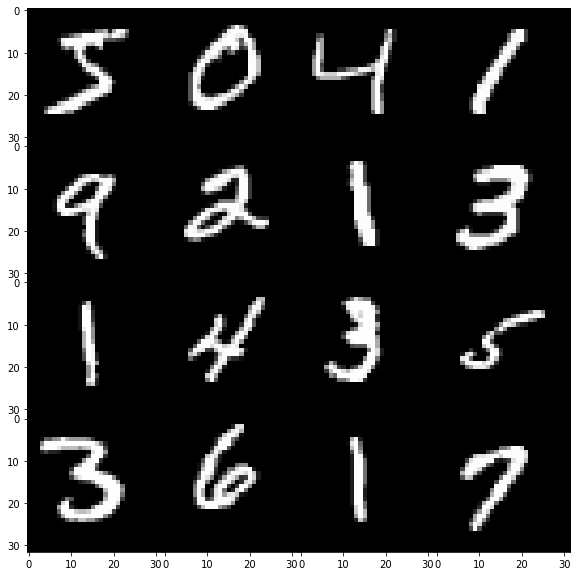

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(20, 10))
grid = ImageGrid(fig, 111,
                nrows_ncols=(4,4),
                axes_pad=0.01,)

for i in range(16):
    grid[i].imshow(X_train[i])

#Encoder

## Transfer Learning

Using EfficientB3 and loading `imagenet` weights.

In [ ]:
!pip install -U git+https://github.com/qubvel/efficientnet
!pip install keras_efficientnets

In [ ]:
from keras_efficientnets import EfficientNetB3
from keras import optimizers

model = EfficientNetB3(include_top=False,
    weights="imagenet",
    input_shape=(32, 32, 3))

model.compile(optimizers.RMSprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

# model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Now we create out encoder part using the previously loaded Efficientnet.

The rest is pretty much like the normal VAE design.

In [ ]:
def sampler(args):

  mu, sigma = args
  
  batch = K.shape(mu)[0]
  dim_latent = mu.shape[1]
  
  eps = K.random_normal(shape=(batch, dim_latent))
  
  return mu + K.exp(sigma / 2) * eps

Like the first part, we choose our latent dimension to be 2.

And since EfficientNet is already trained, `model.trainable` is set to `False`.

A summary of the encoder part can be seen.

In [ ]:
latent_dim = 2
model.trainable = False

input = Input(shape=(32, 32, 3 ), name='input')
x = model(input)
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
mu = Dense(latent_dim, name='mean')(x)
sigma = Dense(latent_dim, name='variance')(x)
z = Lambda(sampler, output_shape=(latent_dim, ), name='sampler')([mu, sigma])

model_final = Model(input, [mu, sigma, z], name='encoder')
model_final.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1, 1, 1536)   10783528    input[0][0]                      
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1536)         0           model_1[1][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         1573888     flatten_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
def kl_reconstruction_loss(true, pred):
  # Reconstruction loss
  reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * ( 32 * 32)
  
  # KL divergence loss
  kl_loss = -1 - sigma + K.square(mu) + K.exp(sigma)
  kl_loss = 0.5 * K.sum(kl_loss, axis=-1)
  
  # Total loss = 50% rec + 50% KL divergence loss
  return 0.5 * reconstruction_loss + 0.5 * kl_loss

# Decoder

The decoder is almost identicall to the decoder of the last part.

And a summary of the model can be seen later on.

In [ ]:
d_input = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(100, activation='relu', name='dense_decoder_1')(d_input)
x = Dense(32 * 32 , activation='relu', name='dense_decoder_2')(x)
x = Reshape((32, 32, 1), name='reshape_decoder')(x)
x = Conv2D(20, kernel_size=(5,5), padding="same",  name='conv')(x)
out = Dense(3, activation='relu', name='output')(x)

decoder = Model(d_input, out, name='decoder')
decoder.compile(optimizer='adam', loss=kl_reconstruction_loss)
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_decoder_1 (Dense)      (None, 100)               300       
_________________________________________________________________
dense_decoder_2 (Dense)      (None, 1024)              103424    
_________________________________________________________________
reshape_decoder (Reshape)    (None, 32, 32, 1)         0         
_________________________________________________________________
conv (Conv2D)                (None, 32, 32, 20)        520       
_________________________________________________________________
output (Dense)               (None, 32, 32, 3)         63        
Total params: 104,307
Trainable params: 104,307
Non-trainable params: 0
_____________________________________________________

# VAE

After creating encoder and decoder its time to compile the VAE as a whole.

In [ ]:
def show_sample(decoder):
    fig = plt.figure(figsize=(20, 10))
    grid = ImageGrid(fig, 111,
                 nrows_ncols=(10,10),
                 axes_pad=0.01,)

    for _ in range(100):
        x = np.random.uniform(-10, 10, size=(2))
        x_decoded = decoder.predict(np.array([x]))
        digit = x_decoded[0].reshape(32, 32 ,3)
        grid[_].imshow(digit)

show_sample(decoder)
plt.show()

In [ ]:
vae = Model(input, decoder(model_final(input)[2]), name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 12361516  
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         104307    
Total params: 12,465,823
Trainable params: 1,682,295
Non-trainable params: 10,783,528
_________________________________________________________________


## Compile and Train

40 epochs seems to be good enough.

Using `kl reconstruction loss` the VAE is compiled.

In [ ]:
import tensorflow as tf
batch_size = 128
n_epochs = 40
validation_split = 0.2

vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

In [ ]:
history = []
for _ in range(4):
    history.append(vae.fit(X_train, X_train, epochs = n_epochs//4, batch_size = batch_size, validation_split = 0.2, shuffle=True))
    show_sample(decoder)
    plt.show()

## Loss plot

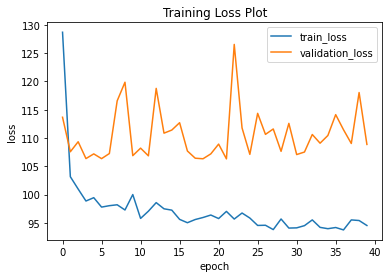

In [ ]:
  def show_train_loss_history(trained, title=None, show_validation=True):
    x1 = []
    x2 = []
    for i in trained:
        for j in i.history['loss']:
            x1.append(j)
        for j in i.history['val_loss']:
            x2.append(j)
    
    plt.plot(x1)
    if(show_validation):
      plt.plot(x2)      
      plt.legend(['train_loss', 'validation_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if(title):
      plt.title(title)
    plt.show()

show_train_loss_history(history, "Training Loss Plot")